In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

commandes_df = pd.read_csv('../RAW_data/clean_data/commandes_merged.csv')
produits_df = pd.read_csv('../RAW_data/clean_data/produits_merged.csv')

produits_df.head()  

,id_produit,catégorie,marque,prix,stock_minimum,date,entrepot,niveau_stock
0,P00001,Soins capillaires,Luxe eclat,467.42,52,01/06/2024,Lyon,88
1,P00001,Soins capillaires,Luxe eclat,467.42,52,22/04/2024,Paris,141
2,P00002,Accessoires,Maison Pure,291.26,10,25/09/2024,Lyon,286
3,P00003,Maquillage,Essentielle Paris,354.39,60,18/02/2024,Paris,177
4,P00003,Maquillage,Essentielle Paris,354.39,60,13/07/2024,Lyon,95


In [2]:
if 'date_retour' in commandes_df.columns:
    commandes_df['return_flag'] = commandes_df['date_retour'].notna().astype(int)
else:
    raise ValueError("La colonne 'date_retour' est manquante dans le fichier.")
commandes_df['date_commande'] = pd.to_datetime(commandes_df['date_commande'], dayfirst=True, errors='coerce')
commandes_df['order_month'] = commandes_df['date_commande'].dt.month
commandes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42458 entries, 0 to 42457
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_commande    42458 non-null  object        
 1   date_commande  42458 non-null  datetime64[ns]
 2   id_produit     42458 non-null  object        
 3   quantité       42458 non-null  int64         
 4   entrepôt       42458 non-null  object        
 5   statut         42458 non-null  object        
 6   date_retour    2987 non-null   object        
 7   motif          2987 non-null   object        
 8   return_flag    42458 non-null  int64         
 9   order_month    42458 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(6)
memory usage: 3.1+ MB


In [3]:
commandes_enriched = commandes_df.merge(
    produits_df[['id_produit', 'catégorie', 'prix']],
    on='id_produit',
    how='left'
)
print(commandes_enriched.head())

  id_commande date_commande id_produit  quantité   entrepôt   statut  \
0     O000001    2024-09-03     P00413         2  Marseille    Livré   
1     O000001    2024-09-03     P00413         2  Marseille    Livré   
2     O000002    2024-11-09     P00778        15       Lyon  Expédié   
3     O000004    2024-11-03     P00535         8       Lyon    Livré   
4     O000004    2024-11-03     P00535         8       Lyon    Livré   

  date_retour motif  return_flag  order_month    catégorie    prix  
0         NaN   NaN            0            9  Accessoires  151.34  
1         NaN   NaN            0            9  Accessoires  151.34  
2         NaN   NaN            0           11  Accessoires  434.14  
3         NaN   NaN            0           11   Maquillage  286.57  
4         NaN   NaN            0           11   Maquillage  286.57  


In [4]:
features = commandes_enriched[[
    'quantité', 'order_month', 'id_produit', 'catégorie', 'prix', 'return_flag'
]]
df_model = features.copy()
cat_cols = df_model.select_dtypes(include='object').columns

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
print(label_encoders)

{'id_produit': LabelEncoder(), 'catégorie': LabelEncoder()}


In [5]:
X = df_model.drop(columns='return_flag')
y = df_model['return_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [6]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     13322
           1       0.24      0.56      0.34      1015

    accuracy                           0.84     14337
   macro avg       0.60      0.71      0.62     14337
weighted avg       0.91      0.84      0.87     14337



In [7]:
commandes_df = pd.read_csv("../RAW_data/clean_data/commandes_merged.csv")
produits_df = pd.read_csv("../RAW_data/clean_data/produits_merged.csv")
expeditions_df = pd.read_csv("../RAW_data/clean_data/expeditionsV2.csv")

commandes_df['return_flag'] = commandes_df['date_retour'].notna().astype(int)
commandes_df['date_commande'] = pd.to_datetime(commandes_df['date_commande'], dayfirst=True, errors='coerce')
commandes_df['order_month'] = commandes_df['date_commande'].dt.month
produits_subset = produits_df[['id_produit', 'catégorie', 'prix', 'marque']]
commandes_produits = commandes_df.merge(produits_subset, on='id_produit', how='left')
expeditions_subset = expeditions_df[['id_commande', 'délai_livraison']]
commandes_enriched = commandes_produits.merge(expeditions_subset, on='id_commande', how='left')
commandes_enriched.columns.tolist()


['id_commande',
 'date_commande',
 'id_produit',
 'quantité',
 'entrepôt',
 'statut',
 'date_retour',
 'motif',
 'return_flag',
 'order_month',
 'catégorie',
 'prix',
 'marque',
 'délai_livraison']

In [8]:
features = commandes_enriched[[
    'quantité', 'order_month', 'id_produit', 'catégorie',
    'prix', 'marque', 'entrepôt', 'statut', 'délai_livraison', 'return_flag'
]].copy()
print(features.head())

   quantité  order_month id_produit    catégorie    prix             marque  \
0         2            9     P00413  Accessoires  151.34  Essentielle Paris   
1         2            9     P00413  Accessoires  151.34  Essentielle Paris   
2        15           11     P00778  Accessoires  434.14   Silhouette Paris   
3         8           11     P00535   Maquillage  286.57        Soin Absolu   
4         8           11     P00535   Maquillage  286.57        Soin Absolu   

    entrepôt   statut  délai_livraison  return_flag  
0  Marseille    Livré                6            0  
1  Marseille    Livré                6            0  
2       Lyon  Expédié                7            0  
3       Lyon    Livré                3            0  
4       Lyon    Livré                3            0  


In [9]:
cat_cols = features.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))
    label_encoders[col] = le

In [10]:
X = features.drop(columns='return_flag')
y = features['return_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
report

'              precision    recall  f1-score   support\n\n           0       0.98      0.99      0.99     13322\n           1       0.87      0.73      0.80      1015\n\n    accuracy                           0.97     14337\n   macro avg       0.93      0.86      0.89     14337\nweighted avg       0.97      0.97      0.97     14337\n'

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [1, 6],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_report = classification_report(y_test, y_pred_best)
best_model_params = grid_search.best_params_
best_report, best_model_params
print(best_report)
print(best_model_params)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


c:\Users\HugoG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\HugoG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\HugoG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\HugoG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13322
           1       0.74      0.78      0.76      1015

    accuracy                           0.96     14337
   macro avg       0.86      0.88      0.87     14337
weighted avg       0.97      0.96      0.97     14337

{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}


In [22]:
X = features.drop(columns='return_flag')
y = features['return_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_params = {
    'n_estimators': 500,
    'max_depth': 30,
    'min_samples_split': 6,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}
optimized_rf_clean = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)
optimized_rf_clean.fit(X_train, y_train)

y_pred_optimized_clean = optimized_rf_clean.predict(X_test)
clean_report = classification_report(y_test, y_pred_optimized_clean)
clean_report

'              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98     13322\n           1       0.74      0.78      0.76      1015\n\n    accuracy                           0.96     14337\n   macro avg       0.86      0.88      0.87     14337\nweighted avg       0.97      0.96      0.97     14337\n'

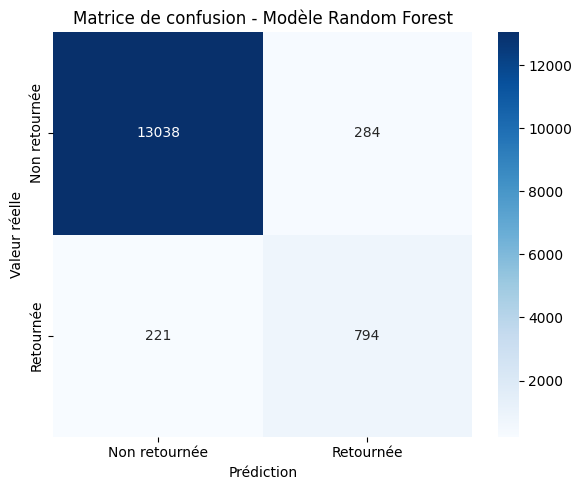

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_optimized_clean)
labels = ['Non retournée', 'Retournée']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédiction")
plt.ylabel("Valeur réelle")
plt.title("Matrice de confusion - Modèle Random Forest")
plt.tight_layout()
plt.show()
